# Sketch Recognition Convolutional Neural Network (CNN)

> - 🤖 See [full list of Machine Learning Experiments](https://github.com/trekhleb/machine-learning-experiments) on **GitHub**<br/><br/>
> - ▶️ **Interactive Demo**: [try this model and other machine learning experiments in action](https://trekhleb.github.io/machine-learning-experiments)

## Experiment overview

In this experiment we will build a [Convolutional Neural Network](https://en.wikipedia.org/wiki/Convolutional_neural_network) (CNN) model using [Tensorflow](https://www.tensorflow.org/) to recognize handwritten sketches by using a [quick-draw dataset](https://github.com/googlecreativelab/quickdraw-dataset).

![sketch_recognition_cnn.png](../../demos/src/images/sketch_recognition_cnn.png)

## Import dependencies

In [2]:
# Selecting Tensorflow version v2 (the command is relevant for Colab only).
# %tensorflow_version 2.x

In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import math
import datetime
import platform
import pathlib
import random

print('Python version:', platform.python_version())
print('Tensorflow version:', tf.__version__)
print('Keras version:', tf.keras.__version__)

Python version: 3.7.6
Tensorflow version: 2.1.0
Keras version: 2.2.4-tf


In [4]:
cache_dir = 'tmp';

In [5]:
# Create cache folder.
!mkdir tmp

mkdir: tmp: File exists


## Load dataset

In [6]:
# List all available datasets to see how the wikipedia dataset is called.
tfds.list_builders()

['abstract_reasoning',
 'aeslc',
 'aflw2k3d',
 'amazon_us_reviews',
 'arc',
 'bair_robot_pushing_small',
 'big_patent',
 'bigearthnet',
 'billsum',
 'binarized_mnist',
 'binary_alpha_digits',
 'c4',
 'caltech101',
 'caltech_birds2010',
 'caltech_birds2011',
 'cars196',
 'cassava',
 'cats_vs_dogs',
 'celeb_a',
 'celeb_a_hq',
 'chexpert',
 'cifar10',
 'cifar100',
 'cifar10_1',
 'cifar10_corrupted',
 'citrus_leaves',
 'cityscapes',
 'civil_comments',
 'clevr',
 'cmaterdb',
 'cnn_dailymail',
 'coco',
 'coil100',
 'colorectal_histology',
 'colorectal_histology_large',
 'cos_e',
 'curated_breast_imaging_ddsm',
 'cycle_gan',
 'deep_weeds',
 'definite_pronoun_resolution',
 'diabetic_retinopathy_detection',
 'dmlab',
 'downsampled_imagenet',
 'dsprites',
 'dtd',
 'duke_ultrasound',
 'dummy_dataset_shared_generator',
 'dummy_mnist',
 'emnist',
 'esnli',
 'eurosat',
 'fashion_mnist',
 'flic',
 'flores',
 'food101',
 'gap',
 'gigaword',
 'glue',
 'groove',
 'higgs',
 'horses_or_humans',
 'i_natura

In [7]:
DATASET_NAME = 'quickdraw_bitmap'

dataset, dataset_info = tfds.load(
    name=DATASET_NAME,
    data_dir=cache_dir,
    with_info=True,
    split=tfds.Split.TRAIN,
)

## Explore dataset

In [166]:
print(dataset_info)

tfds.core.DatasetInfo(
    name='quickdraw_bitmap',
    version=3.0.0,
    description='The Quick Draw Dataset is a collection of 50 million drawings across 345 categories, contributed by players of the game Quick, Draw!. The bitmap dataset contains these drawings converted from vector format into 28x28 grayscale images',
    homepage='https://github.com/googlecreativelab/quickdraw-dataset',
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=345),
    }),
    total_num_examples=50426266,
    splits={
        'train': 50426266,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{DBLP:journals/corr/HaE17,
      author    = {David Ha and
                   Douglas Eck},
      title     = {A Neural Representation of Sketch Drawings},
      journal   = {CoRR},
      volume    = {abs/1704.03477},
      year      = {2017},
      url       = {http://arxiv.org/abs/1704.03477

In [167]:
image_shape = dataset_info.features['image'].shape
num_classes = dataset_info.features['label'].num_classes
num_examples = dataset_info.splits['train'].num_examples

print('num_examples: ', num_examples)
print('image_shape: ', image_shape)
print('num_classes: ', num_classes)

num_examples:  50426266
image_shape:  (28, 28, 1)
num_classes:  345


In [168]:
label_index_to_string = dataset_info.features['label'].int2str

classes = []

for class_index in range(num_classes):
    classes.append(label_index_to_string(class_index))
    
print('classes num:', len(classes))
print('classes:\n\n', classes)

classes num: 345
classes:

 ['aircraft carrier', 'airplane', 'alarm clock', 'ambulance', 'angel', 'animal migration', 'ant', 'anvil', 'apple', 'arm', 'asparagus', 'axe', 'backpack', 'banana', 'bandage', 'barn', 'baseball bat', 'baseball', 'basket', 'basketball', 'bat', 'bathtub', 'beach', 'bear', 'beard', 'bed', 'bee', 'belt', 'bench', 'bicycle', 'binoculars', 'bird', 'birthday cake', 'blackberry', 'blueberry', 'book', 'boomerang', 'bottlecap', 'bowtie', 'bracelet', 'brain', 'bread', 'bridge', 'broccoli', 'broom', 'bucket', 'bulldozer', 'bus', 'bush', 'butterfly', 'cactus', 'cake', 'calculator', 'calendar', 'camel', 'camera', 'camouflage', 'campfire', 'candle', 'cannon', 'canoe', 'car', 'carrot', 'castle', 'cat', 'ceiling fan', 'cell phone', 'cello', 'chair', 'chandelier', 'church', 'circle', 'clarinet', 'clock', 'cloud', 'coffee cup', 'compass', 'computer', 'cookie', 'cooler', 'couch', 'cow', 'crab', 'crayon', 'crocodile', 'crown', 'cruise ship', 'cup', 'diamond', 'dishwasher', 'divin

In [162]:
print(dataset)

<DatasetV1Adapter shapes: {image: (28, 28, 1), label: ()}, types: {image: tf.uint8, label: tf.int64}>


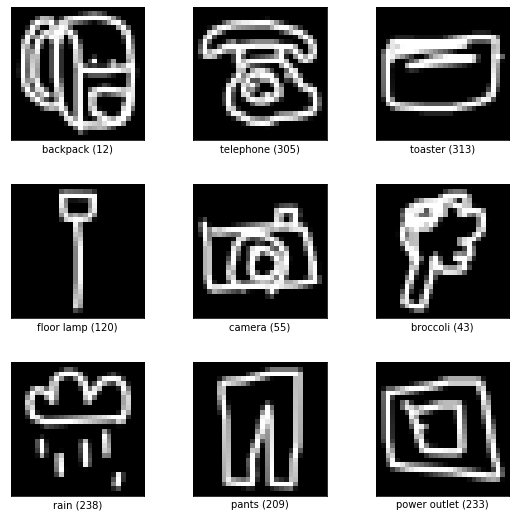

In [163]:
fig = tfds.show_examples(dataset_info, dataset)

In [203]:
def dataset_preview(dataset, image_shape, preview_images_num=100):
    num_cells = math.ceil(math.sqrt(preview_images_num))
    plt.figure(figsize=(17, 17))
    image_size = image_shape[0]
    
    for image_index, example in enumerate(dataset.take(preview_images_num)):
        image = example['image']
        label = example['label']
        
        class_index = label.numpy()
        class_name = classes[class_index]
        
        plt.subplot(num_cells, num_cells, image_index + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(
            np.reshape(image, (image_size, image_size)),
            cmap=plt.cm.binary
        )
        plt.xlabel('{} ({})'.format(class_name, class_index))
    plt.show()

In [213]:
def dataset_normalized_preview(dataset, image_shape, preview_images_num=100):
    num_cells = math.ceil(math.sqrt(preview_images_num))
    plt.figure(figsize=(17, 17))
    image_size = image_shape[0]
    
    for image_index, example in enumerate(dataset.take(preview_images_num)):
        image = example[0]
        label = tf.math.argmax(example[1])
        
        class_index = label.numpy()
        class_name = label_index_to_string(class_index)
        
        plt.subplot(num_cells, num_cells, image_index + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(
            np.reshape(image, (image_size, image_size)),
            cmap=plt.cm.binary
        )
        plt.xlabel('{} ({})'.format(class_name, class_index))
    plt.show()

In [205]:
def dataset_head(ds):
    for example in ds.take(1):
        image = example['image']
        label = example['label']

        class_index = label.numpy()
        class_name = label_index_to_string(class_index)

        print('{} ({})'.format(class_name, class_index), '\n')
        print('Image shape: ', image.shape, '\n')
        print(np.reshape(image.numpy(), (28, 28)), '\n')

In [206]:
dataset_head(dataset)

backpack (12) 

Image shape:  (28, 28, 1) 

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   3  31  63  95 115
   86  50   2   0   0   0   0   0   0   0]
 [  0   0   0   0   0  75 183 176 152  10  54 182 222 250 255 255 255 255
  255 255 231 151  61   0   0   0   0   0]
 [  0   0   0   0 129 255 216 202 255  98 220 222 157 125  93  60  28   8
   38  82 162 239 254 108   0   0   0   0]
 [  0   0   0  33 250 158   4   0 204 209 255 236 105   0   0   0   0   0
    0   0   0   6 164 254  88   0   0   0]
 [  0   0   0 158 243  30 155 235 211 255 254 185 255  97   0   0   0   0
    0   0   0   0   3 193 229  10   0   0]
 [  0   0  38 251 134 153 251 162 252 245 225   1 180 241   6   0   0   0
    0   0   0   0   0  69 255  62   0   0]
 [  0   0 150 240  26 245 145   0 116 255 149   0  75 255  58   0   0   0
    0   0   0   0   0  29 255  94   0   0]
 [  0   0 209 173  7

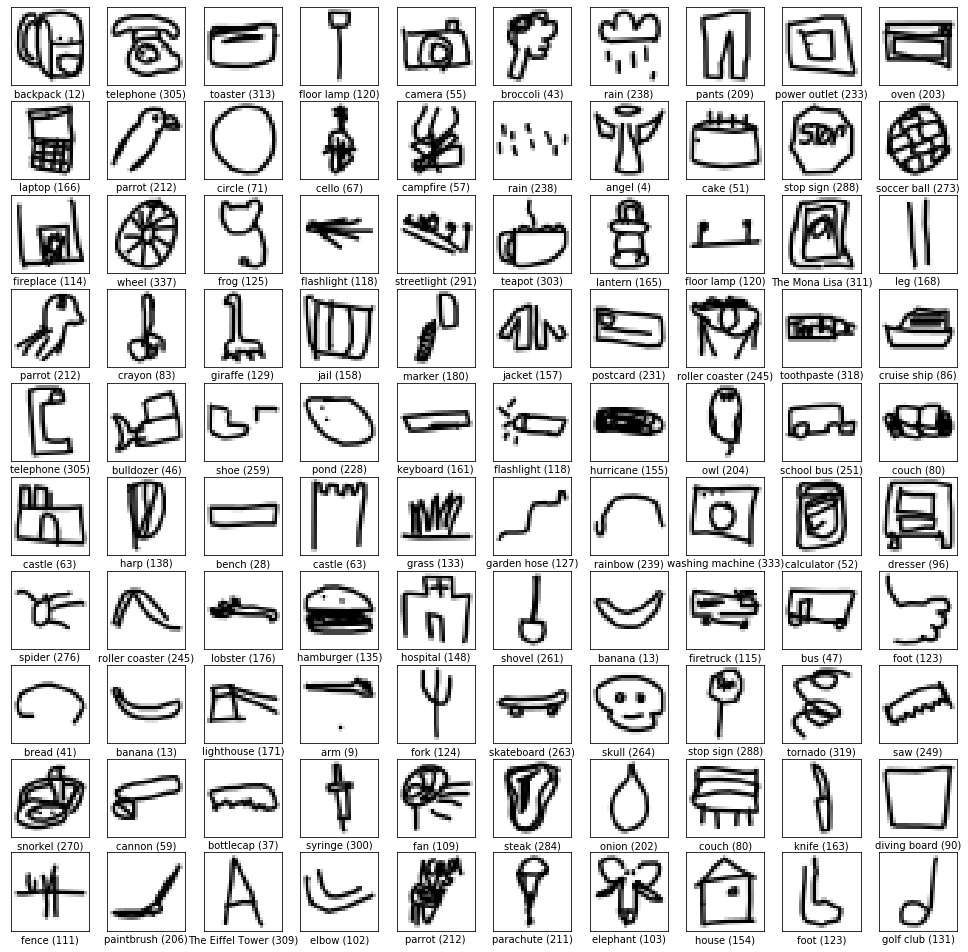

In [207]:
dataset_preview(dataset, image_shape)

## Normalize dataset

In [208]:
def normalize_example(example):
    image = example['image']
    label = example['label']
    label = tf.one_hot(label, len(classes))
    
    image = tf.math.divide(image, 255)
    
    return (image, label)

In [209]:
def augment_example(image, label):
    image = tf.image.random_flip_left_right(image)
    return (image, label)

In [210]:
dataset_normalized = dataset.map(normalize_example).map(augment_example)

In [211]:
for (image, label) in dataset_normalized.take(1):
    class_index = tf.math.argmax(label).numpy()
    class_name = label_index_to_string(class_index)

    print('{} ({})'.format(class_name, class_index), '\n')
    print('Image shape: ', image.shape, '\n')
    print(np.reshape(image.numpy(), (28, 28)), '\n')

backpack (12) 

Image shape:  (28, 28, 1) 

[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.01176471 0.12156863 0.24705882 0.37254903 0.4509804
  0.3372549  0.19607843 0.00784314 0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.29411766
  0.7176471  0.6901961  0.59607846 0.03921569 0.21176471 0.7137255
  0.87058824 0.98039216 1.         1.         1.         1.
  1.         1.         0.90588236 0.5921569  0.23921569 0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.5058824  1.
  0.84705883 

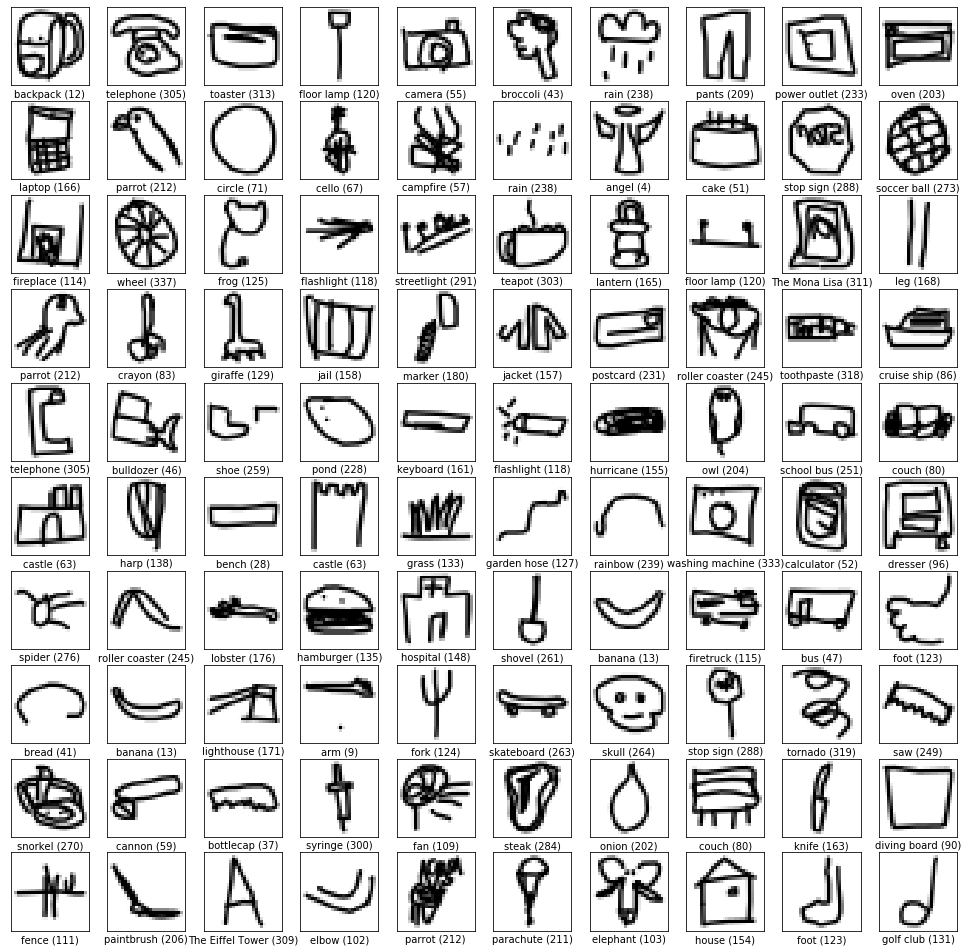

In [214]:
dataset_normalized_preview(dataset_normalized, image_shape)

## Prepare Train/Validation/Test dataset splits

In [215]:
# A quick example of how we're going to split the dataset for train/test/validation subsets.
tmp_ds = tf.data.Dataset.range(10)
print('tmp_ds:', list(tmp_ds.as_numpy_iterator()))

tmp_ds_test = tmp_ds.take(2)
print('tmp_ds_test:', list(tmp_ds_test.as_numpy_iterator()))

tmp_ds_val = tmp_ds.skip(2).take(3)
print('tmp_ds_val:', list(tmp_ds_val.as_numpy_iterator()))

tmp_ds_train = tmp_ds.skip(2 + 3)
print('tmp_ds_train:', list(tmp_ds_train.as_numpy_iterator()))

tmp_ds: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
tmp_ds_test: [0, 1]
tmp_ds_val: [2, 3, 4]
tmp_ds_train: [5, 6, 7, 8, 9]


In [378]:
# Dataset split
test_dataset_batches = 1
val_dataset_batches = 1

# Dataset batching
batch_size = 2000
prefetch_buffer_batches = 10

# Training
epochs = 40
steps_per_epoch = 500

In [379]:
dataset_batched = dataset_normalized.batch(batch_size=batch_size)

In [380]:
# TEST dataset.
dataset_test = dataset_batched \
    .take(test_dataset_batches)

# VALIDATION dataset.
dataset_val = dataset_batched \
    .skip(test_dataset_batches) \
    .take(val_dataset_batches)

# TRAIN dataset.
dataset_train = dataset_batched \
    .skip(test_dataset_batches + val_dataset_batches) \
    .prefetch(buffer_size=prefetch_buffer_batches) \
    .repeat()

In [381]:
for (image_test, label_test) in dataset_test.take(1):
    print('label_test.shape: ', label_test.shape)
    print('image_test.shape: ', image_test.shape)
    
print()    
    
for (image_val, label_val) in dataset_val.take(1):
    print('label_val.shape: ', label_val.shape)
    print('image_val.shape: ', image_val.shape)    
    
print()    
    
for (image_train, label_train) in dataset_train.take(1):
    print('label_train.shape: ', label_train.shape)
    print('image_train.shape: ', image_train.shape)    

label_test.shape:  (2000, 345)
image_test.shape:  (2000, 28, 28, 1)

label_val.shape:  (2000, 345)
image_val.shape:  (2000, 28, 28, 1)

label_train.shape:  (2000, 345)
image_train.shape:  (2000, 28, 28, 1)


In [382]:
# Calculate how many times the network will "see" each class during one epoch of training
# given specific dataset (batches) and number of steps per epoch.
def get_dataset_classes_hist(dataset, classes, batches_num):
    mentions = {class_name: 0 for class_name in classes}
    for examples, labels in dataset.take(batches_num):
        for label in labels:
            class_name = classes[tf.math.argmax(label).numpy()]
            mentions[class_name] += 1    
    return mentions;

In [383]:
mentions = get_dataset_classes_hist(
    dataset_train,
    classes,
    batches_num=steps_per_epoch
)

In [384]:
for class_name in mentions:
    print('{:15s}: {}'.format(class_name, mentions[class_name]))

aircraft carrier: 2295
airplane       : 3030
alarm clock    : 2458
ambulance      : 2842
angel          : 2926
animal migration: 2706
ant            : 2548
anvil          : 2553
apple          : 2904
arm            : 2373
asparagus      : 3351
axe            : 2473
backpack       : 2429
banana         : 6052
bandage        : 2935
barn           : 2956
baseball bat   : 2381
baseball       : 2668
basket         : 2278
basketball     : 2662
bat            : 2371
bathtub        : 3429
beach          : 2515
bear           : 2679
beard          : 3318
bed            : 2346
bee            : 2417
belt           : 3876
bench          : 2531
bicycle        : 2501
binoculars     : 2432
bird           : 2619
birthday cake  : 3036
blackberry     : 2570
blueberry      : 2537
book           : 2389
boomerang      : 2918
bottlecap      : 3091
bowtie         : 2549
bracelet       : 2394
brain          : 2770
bread          : 2356
bridge         : 2638
broccoli       : 2613
broom          : 2347
bucket  

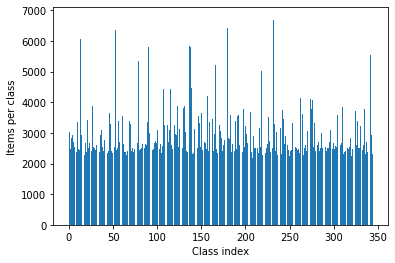

In [385]:
mantions_x = [class_index for class_index, class_name in enumerate(classes)]
mantions_bars = [mentions[class_name] for class_name in mentions]

plt.bar(mantions_x, mantions_bars)
plt.xlabel('Class index')
plt.ylabel('Items per class')
plt.show()

## Create model

In [386]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Convolution2D(
    input_shape=image_shape,
    kernel_size=5,
    filters=32,
    padding='same',
    activation=tf.keras.activations.relu
))
model.add(tf.keras.layers.MaxPooling2D(
    pool_size=2,
    strides=2
))

model.add(tf.keras.layers.Convolution2D(
    kernel_size=3,
    filters=32,
    padding='same',
    activation=tf.keras.activations.relu,
))
model.add(tf.keras.layers.MaxPooling2D(
    pool_size=2,
    strides=2
))

model.add(tf.keras.layers.Convolution2D(
    kernel_size=3,
    filters=64,
    padding='same',
    activation=tf.keras.activations.relu
))
model.add(tf.keras.layers.MaxPooling2D(
    pool_size=2,
    strides=2
))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(
    units=512,
    activation=tf.keras.activations.relu
))

model.add(tf.keras.layers.Dense(
    units=num_classes,
    activation=tf.keras.activations.softmax
))

In [387]:
model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_57 (Conv2D)           (None, 28, 28, 32)        832       
_________________________________________________________________
max_pooling2d_57 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_58 (MaxPooling (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_59 (MaxPooling (None, 3, 3, 64)          0         
_________________________________________________________________
flatten_19 (Flatten)         (None, 576)             

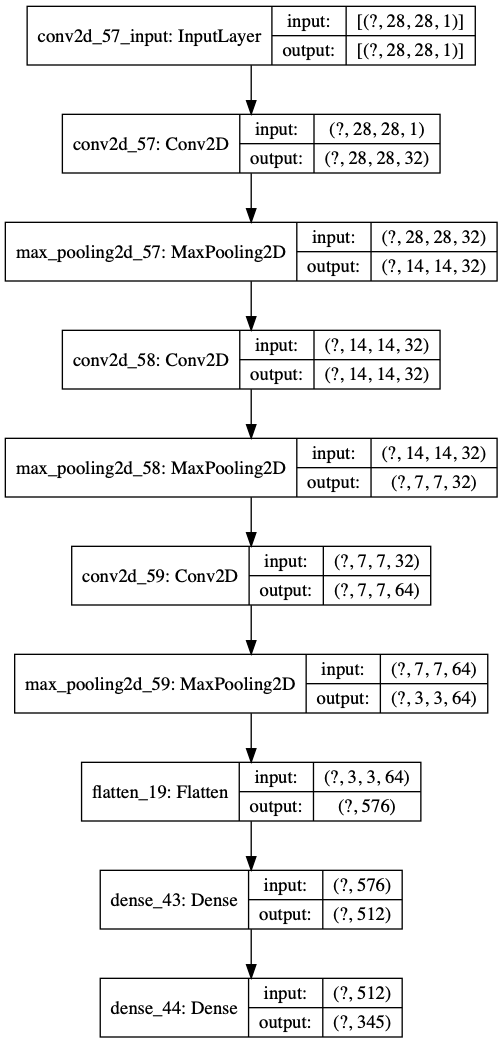

In [388]:
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
)

In [389]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.003)
rms_prop_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
sgd_optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

model.compile(
    optimizer=adam_optimizer,
    loss=tf.keras.losses.categorical_crossentropy,
    metrics=['accuracy']
)

## Train model

In [390]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    patience=5,
    monitor='val_accuracy',
    restore_best_weights=True,
    verbose=1
)

In [ ]:
training_history = model.fit(
    x=dataset_train,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=dataset_val,
    callbacks=[
        early_stopping_callback
    ]
)

In [393]:
# Renders the charts for training accuracy and loss.
def render_training_history(training_history):
    loss = training_history.history['loss']
    val_loss = training_history.history['val_loss']

    accuracy = training_history.history['accuracy']
    val_accuracy = training_history.history['val_accuracy']

    plt.figure(figsize=(14, 4))

    plt.subplot(1, 2, 1)
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(loss, label='Training set')
    plt.plot(val_loss, label='Test set', linestyle='--')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)

    plt.subplot(1, 2, 2)
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(accuracy, label='Training set')
    plt.plot(val_accuracy, label='Test set', linestyle='--')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)

    plt.show()

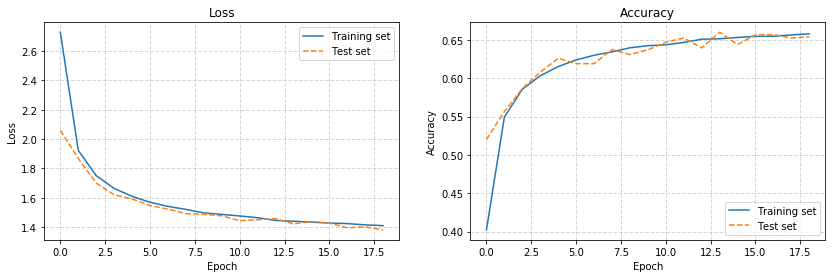

In [394]:
render_training_history(training_history)

## Evaluate model accuracy

### Training set accuracy

In [395]:
%%capture
train_loss, train_accuracy = model.evaluate(dataset_train.take(1))

In [396]:
print('Train loss: ', '{:.2f}'.format(train_loss))
print('Train accuracy: ', '{:.2f}'.format(train_accuracy))

Train loss:  1.36
Train accuracy:  0.66


### Validation set accuracy

In [397]:
%%capture
val_loss, val_accuracy = model.evaluate(dataset_val)

In [398]:
print('Validation loss: ', '{:.2f}'.format(val_loss))
print('Validation accuracy: ', '{:.2f}'.format(val_accuracy))

Validation loss:  1.43
Validation accuracy:  0.65


### Test set accuracy

In [399]:
%%capture
test_loss, test_accuracy = model.evaluate(dataset_test)

In [400]:
print('Test loss: ', '{:.2f}'.format(test_loss))
print('Test accuracy: ', '{:.2f}'.format(test_accuracy))

Test loss:  1.40
Test accuracy:  0.67


### Visualizing Predictions

In [422]:
def visualize_predictions(model, dataset):
    numbers_to_display = 64
    num_cells = math.ceil(math.sqrt(numbers_to_display))
    plt.figure(figsize=(15, 15))
    
    batch = dataset.take(1)
    predictions = tf.math.argmax(model.predict(batch), axis=1).numpy()

    for x, y in batch:
        for image_index in range(numbers_to_display):
            pixels = np.reshape(x[image_index].numpy(), (28, 28))
            y_correct = tf.math.argmax(y[image_index]).numpy()
            y_predicted = predictions[image_index]
            correct_label = classes[y_correct]
            predicted_label = classes[y_predicted]
            
            plt.xticks([])
            plt.yticks([])
            plt.grid(False)
            color_map = 'Greens' if y_correct == y_predicted else 'Reds'
            plt.subplot(num_cells, num_cells, image_index + 1)
            plt.imshow(pixels, cmap=color_map)
            plt.xlabel(correct_label + ' --> ' + predicted_label)
            
    plt.subplots_adjust(hspace=1, wspace=0.5)
    plt.show()

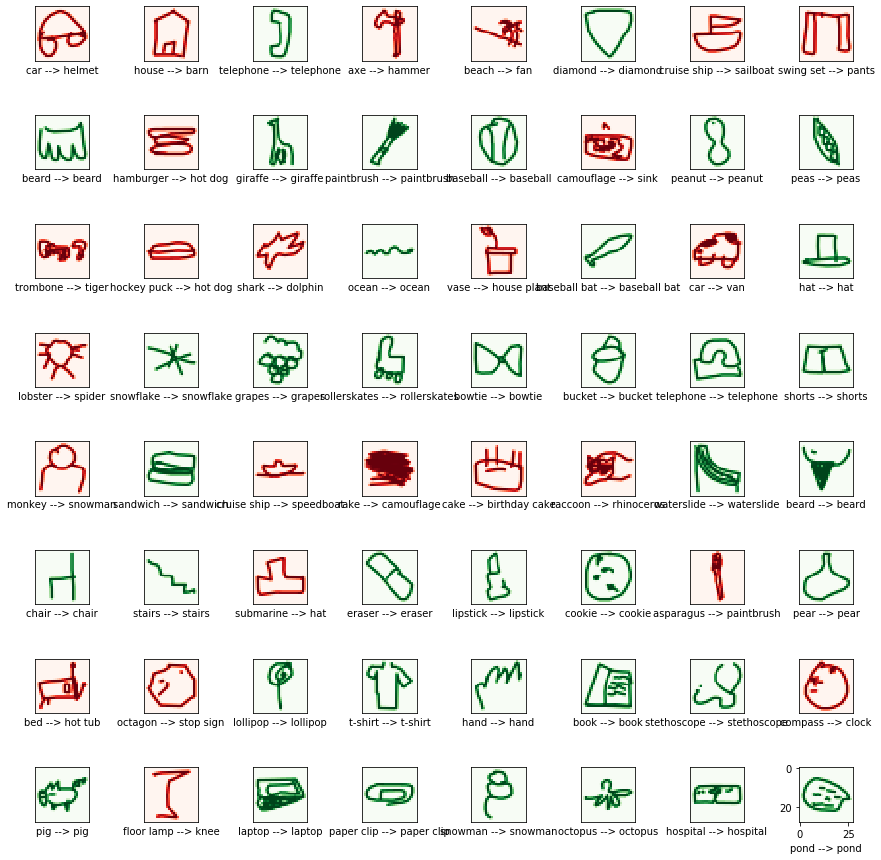

In [423]:
visualize_predictions(model, dataset_train)

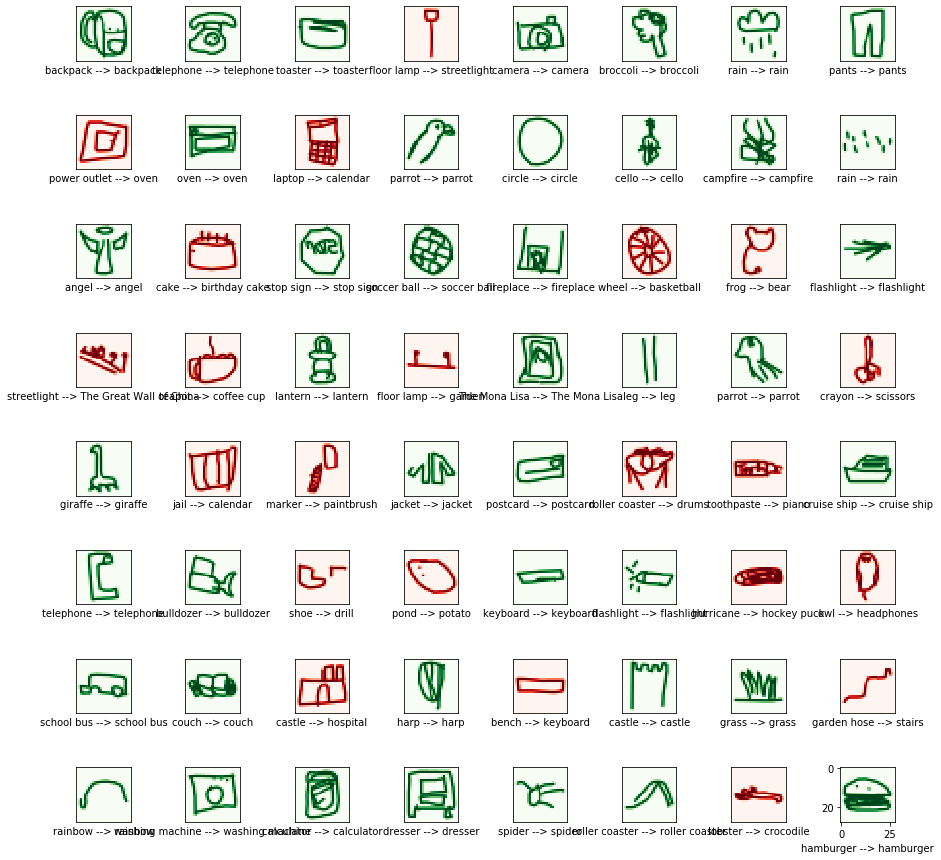

In [424]:
visualize_predictions(model, dataset_test)

## Save the model

We will save the entire model to a `HDF5` file. The `.h5` extension of the file indicates that the model should be saved in Keras format as HDF5 file. To use this model on the front-end we will convert it (later in this notebook) to Javascript understandable format (`tfjs_layers_model` with .json and .bin files) using [tensorflowjs_converter](https://www.tensorflow.org/js/tutorials/conversion/import_saved_model) as it is specified in the [main README](https://github.com/trekhleb/machine-learning-experiments).

In [425]:
model_name = 'sketch_recognition_cnn.h5'
model.save(model_name, save_format='h5')

## Converting the model to web-format

To use this model on the web we need to convert it into the format that will be understandable by [tensorflowjs](https://www.tensorflow.org/js). To do so we may use [tfjs-converter](https://github.com/tensorflow/tfjs/tree/master/tfjs-converter) as following:

```
tensorflowjs_converter --input_format keras \
  ./experiments/sketch_recognition_cnn/sketch_recognition_cnn.h5 \
  ./demos/public/models/sketch_recognition_cnn
```

You find this experiment in the [Demo app](https://trekhleb.github.io/machine-learning-experiments) and play around with it right in you browser to see how the model performs in real life.